# **Hourly Energy Consumption**

In [20]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving PJME hourly.csv to PJME hourly.csv
User uploaded file "PJME hourly.csv" with length 4070265 bytes


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Lambda,GRU,Dropout,Bidirectional
import math
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")




In [22]:
df=pd.read_csv("PJME hourly.csv", index_col=[0],parse_dates=[0])
df.tail(5)

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


Text(0.5, 1.0, 'Hourly Energy Consumption data (2002-2018)')

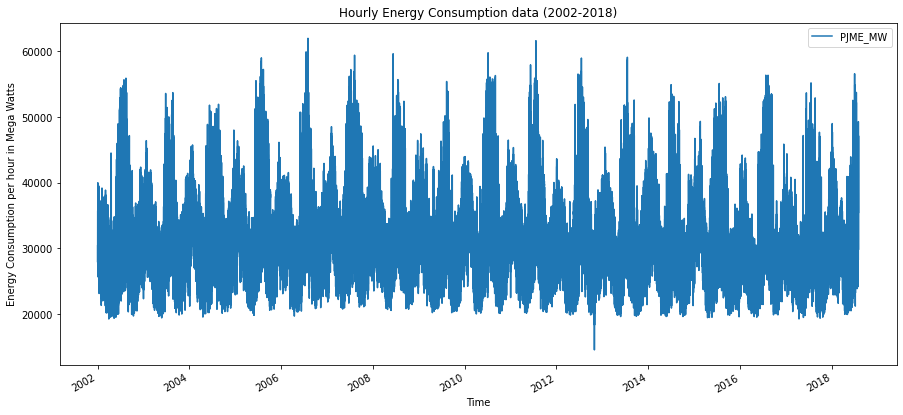

In [24]:
#Visualisation
df.plot(figsize=(15,7))
plt.xlabel("Time")
plt.ylabel("Energy Consumption per hour in Mega Watts")
plt.title("Hourly Energy Consumption data (2002-2018)")


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
#Scaling the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df["PJME_MW"]=scaler.fit_transform(df["PJME_MW"].values.reshape(-1,1))

#series shape=(145366,1)

Text(0.5, 1.0, 'Hourly Energy Consumption data (2002-2018)')

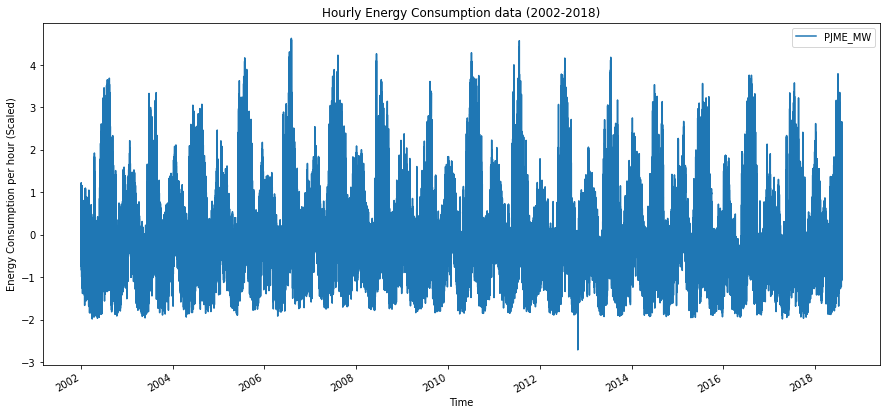

In [27]:
#visualisation after scaling
df.plot(figsize=(15,7))
plt.xlabel("Time")
plt.ylabel("Energy Consumption per hour (Scaled)")
plt.title("Hourly Energy Consumption data (2002-2018)")
#df shape =(145366, 1)

## **Transforming Dataset**

In [0]:
time=np.array(range(len(df)))
series=np.array(df["PJME_MW"])
#time.shape,series.shape = ((145366,), (145366,))

In [0]:
split=105000
x_train=series[:split]
time_train=time[:split]
x_test=series[split:]
time_test=time[split:]

#x_train.shape=(105000,)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset



## **Building the Model**

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size=32
batch_size=64
shuffle_buffer_size=5000

ds=windowed_dataset(x_train, window_size,batch_size,shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True,dropout=0.15)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True,dropout=0.2)),
  tf.keras.layers.Dense(32,activation="relu"),
  tf.keras.layers.Dense(1)

])

adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error',optimizer=adam,metrics=['mean_absolute_error'])

history=model.fit(ds,epochs=50)



Epoch 1/50
1641/1641 [==============================] - 21s 13ms/step - loss: 0.1122 - mean_absolute_error: 0.2423
Epoch 2/50
1641/1641 [==============================] - 21s 13ms/step - loss: 0.0443 - mean_absolute_error: 0.1579
Epoch 3/50
1641/1641 [==============================] - 22s 13ms/step - loss: 0.0312 - mean_absolute_error: 0.1298
Epoch 4/50
1641/1641 [==============================] - 21s 13ms/step - loss: 0.0244 - mean_absolute_error: 0.1123
Epoch 5/50
1641/1641 [==============================] - 21s 13ms/step - loss: 0.0212 - mean_absolute_error: 0.1026
Epoch 6/50
1641/1641 [==============================] - 21s 13ms/step - loss: 0.0185 - mean_absolute_error: 0.0948
Epoch 7/50
1641/1641 [==============================] - 21s 13ms/step - loss: 0.0169 - mean_absolute_error: 0.0894
Epoch 8/50
1641/1641 [==============================] - 20s 12ms/step - loss: 0.0156 - mean_absolute_error: 0.0853
Epoch 9/50
1641/1641 [==============================] - 21s 13ms/step - loss: 0.

## **Forecasting**

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split - window_size:-1, -1, 0]


## **Evaluating Our Model**

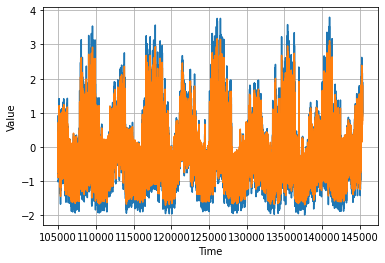

In [41]:
plot_series(time_test, x_test)
plot_series(time_test,rnn_forecast)

In [42]:
rnn_score = r2_score(x_test,rnn_forecast )
rnn_score

0.9692045340601124

In [43]:
tf.keras.metrics.mean_absolute_error(x_test, rnn_forecast).numpy()

0.13269451